# Purpose

Create a mechanism free model to predict lattice spacing change (percent change from mean) from: 'M3_i', 'M6_c', 'I20_I10' & 'A59_c' (data given as percent change from mean); in addition to these pieces at the same time point as D10, the model also has access to these data at 6 time points previous since lattice kinematics may depend not only on the current state of the system, but also on time history. This is done by giving the model access to time shifted columns, and one row of data per each prediction. 

The first iteration of the model trains on 75% of a trial's data, then tests on the other 25% of the trial's data. 

The second iteration of the model trains on all but one trial in the set of acceptable trials. It tests on the withheld trial, whose data it has never seen. The model is rebuilt for each withheld trial. 

xGBoost is a random forest based gradient descent method that seeks to minimize an error function by iteratively reweighting the predicted data that isn't handled well by the model at each stage of creation. https://www.datacamp.com/community/tutorials/xgboost-in-python

In [6]:
import numpy as np 
import pandas 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score # This seems to only work for classification
from sklearn.metrics import explained_variance_score
import math



# Plot parameters 

import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

In [3]:
# These are the trials that we have good data for 

acceptable_trials = ['m07_t01_15', 'm07_t03_15', 'm07_t06_15','m10_t02_16','m11_t02_16','m11_t04_16',
                   'm12_t02_16','m14_t05_16', 'm14_t03_16', 'm15_t01_16', 'm15_t03_16']



In [4]:
# Kwarg variables for the xGBoost regressor
obj ='reg:linear'
csbt = .15 
lr = .15
md = 3
n_est = 50
ss = .25
alp = 1


# Goal 1:
## Within trial predictions

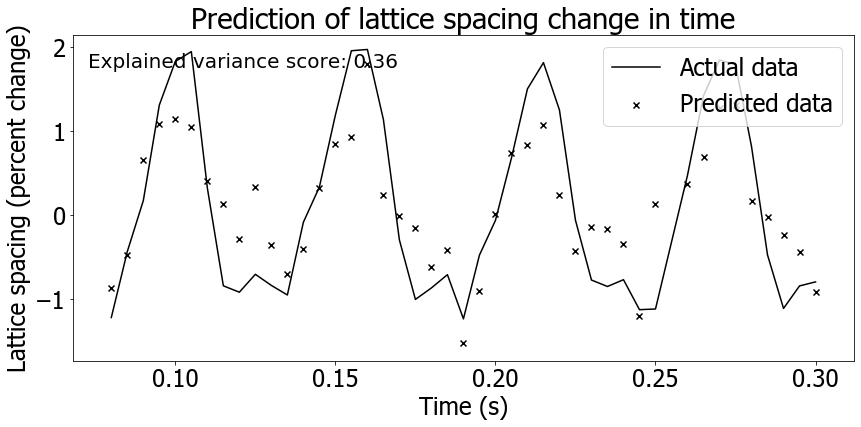

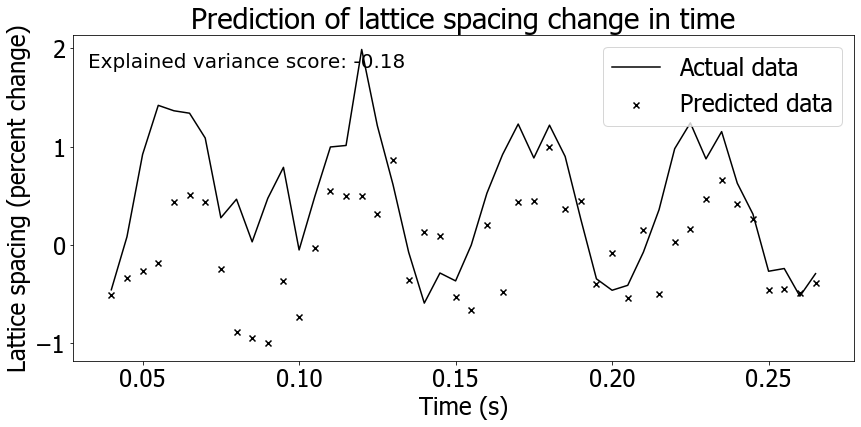

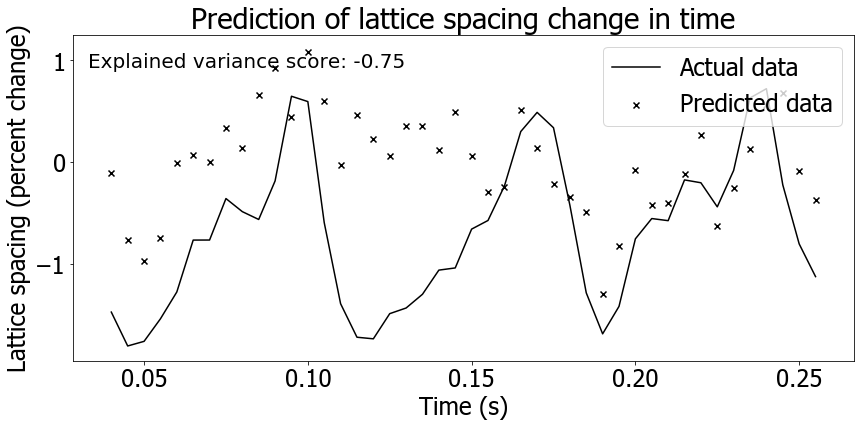

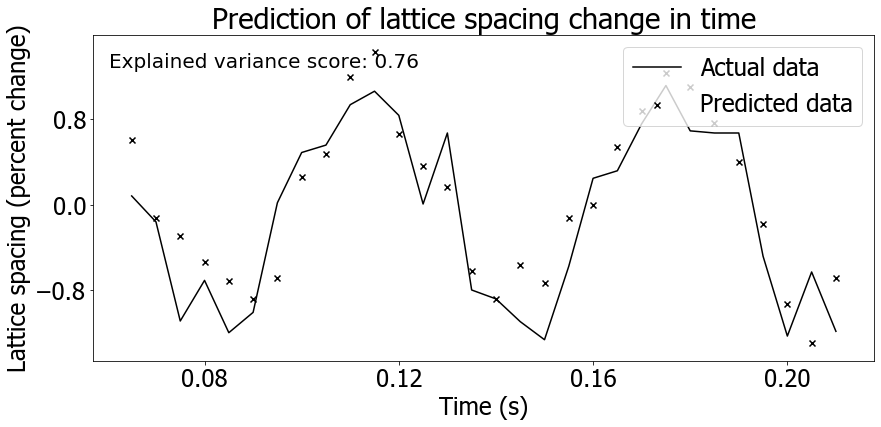

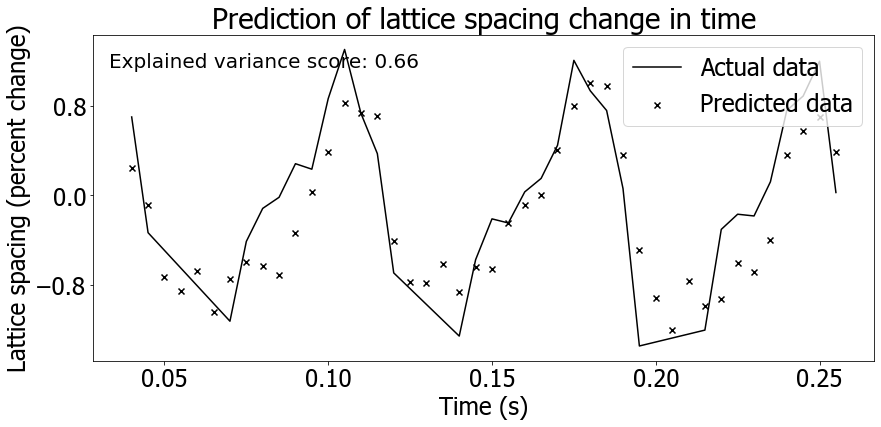

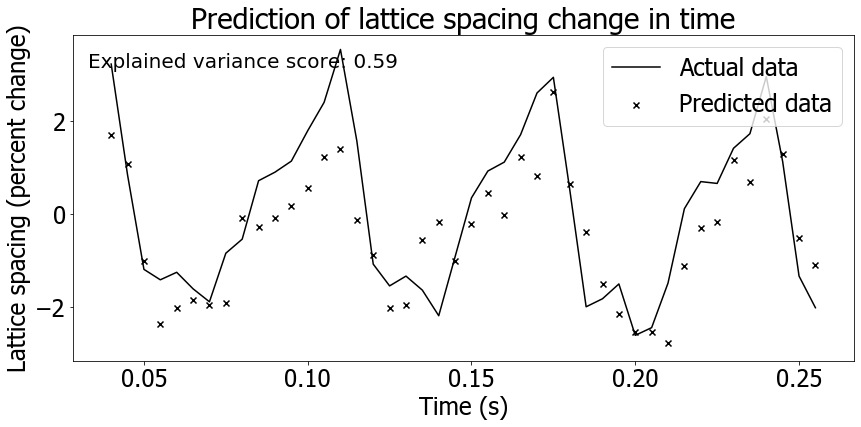

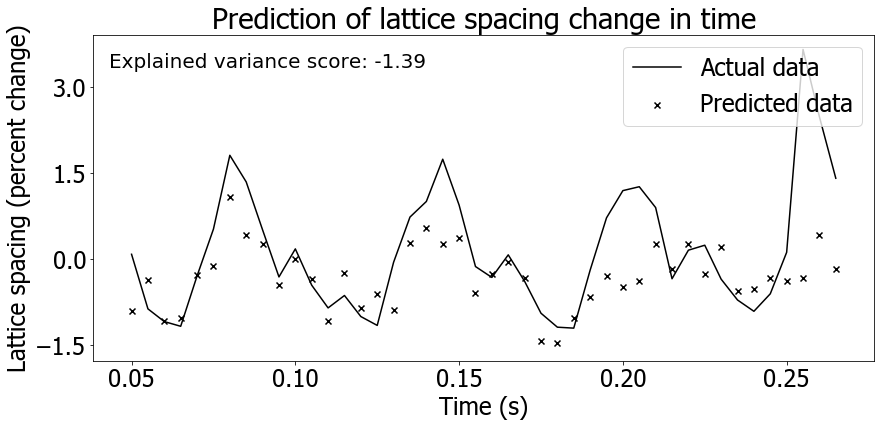

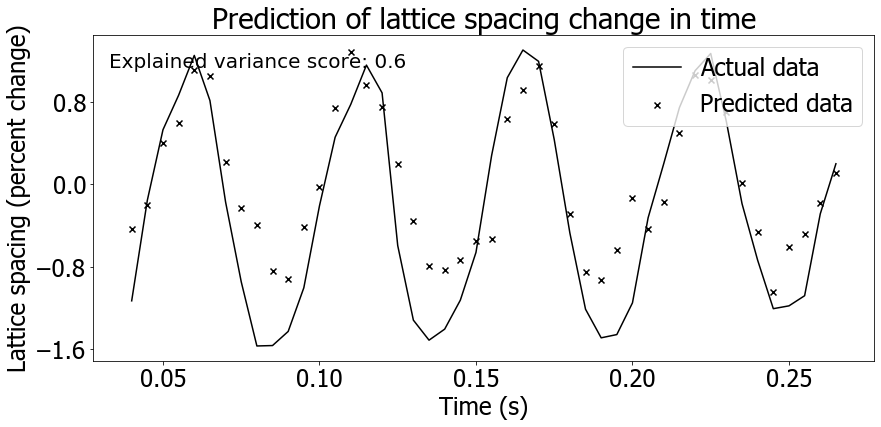

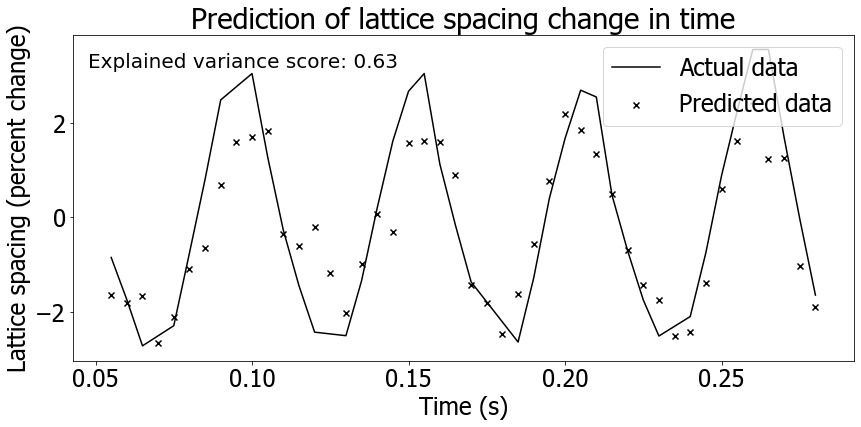

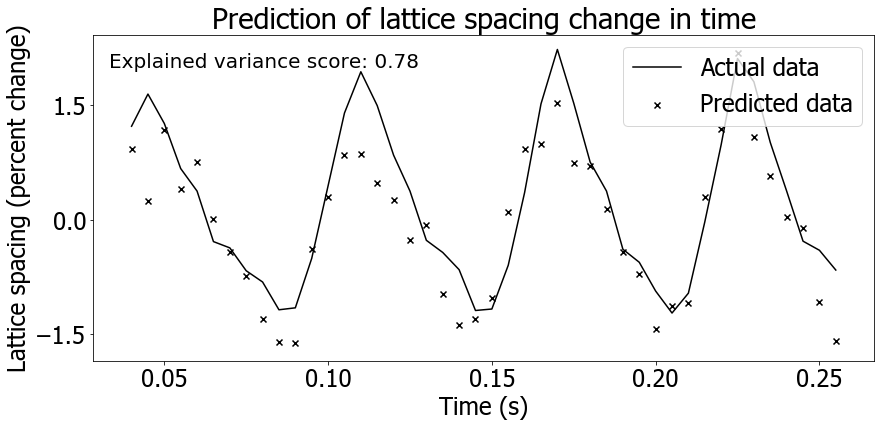

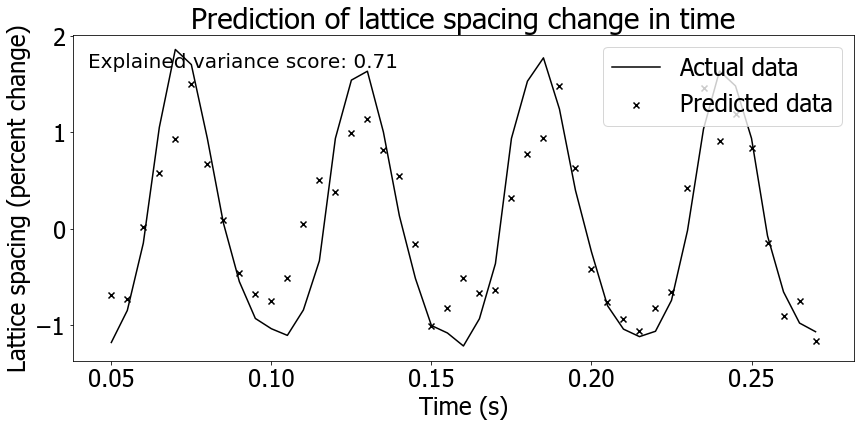

In [7]:
## Within trial 

exp_var = pandas.DataFrame((np.zeros((len(acceptable_trials),2)))*np.nan, index = [np.arange(0,len(acceptable_trials))], columns = ['Explained_variance', 'rms'])
count = 0


for trial in acceptable_trials:
    # Build the regressor object with optional kwargs -- this will be the same throughout. 
    xg_reg = xgb.XGBRegressor(objective =obj, colsample_bytree = csbt, learning_rate = lr,
                max_depth = md, n_estimators = n_est, subsample = ss, alpha = alp)
    
    # Import data 
    d = pandas.read_csv('../DataProcessing/ProcessedData/' + trial + '_det.csv')
    d = d[['D10', 'D11', 'D20', 'I20I11_I10', 'I20_I10',
           'fitting_error', 'seconds', 'tif_num', 'M3_c', 'M6_c', 'A51_c', 'A59_c',
           'M3_i', 'M6_i', 'A59_i', 'A51_i', 'Sum', 'peaks', 'ISI']]
    
    # Normalize all data to percent of mean
    d['M3_c'] = 100*(d.M3_c/d.M3_c.mean() - 1)
    d['M6_c'] = 100*(d.M6_c/d.M6_c.mean() - 1)
    d['A59_c'] = 100*(d.A59_c/d.A59_c.mean() - 1)
    d['D10'] = 100*(d.D10/d.D10.mean() - 1)
    d['I20_I10'] = 100*(d.I20_I10/d.I20_I10.mean() - 1)
    
    # Fill nans using interpolate
    d = d.interpolate()
    
    # Add wingbeat frequency
    d['Wingbeat_freq'] = d.ISI.max()
    
    # Subset to desired columns
    d = d[['D10', 'I20_I10', 'M3_i', 'A59_c', 'M6_c', 'Wingbeat_freq', 'seconds', 'peaks']]
    
    # Drop any rows that have a nan
    d = d.dropna(how = 'any').reset_index(drop = 'True')
    
    # Add time history in the form of time shifted columns
    # I chose to  do this in a recursive style, referencing the j-1 shift and shifting it further by 1. It could be done without the recursion.
    columns = ['M3_i', 'M6_c', 'I20_I10', 'A59_c']
    shift_column_names = []
    for col in columns:
        d[col + '_' + str(0)] = d[col].shift(-1)
        shift_column_names.append(col + '_' + str(0))

    for j in np.arange(1,6):
        for col in columns:
            d[col + '_' + str(j)] = d[col + '_' + str(j-1)].shift(-1)
            shift_column_names.append(col + '_' + str(j))
            
            
    # This dropna will actually cut the total length of the dataframe since by time shifting there will be some columns that are nearly a whole ISI shorter than the original data length      
    d = d.dropna()
    
    
    # Subset the data into predictors (X) and predicted (y)
    modeled_data = 'D10'
    X = (d[columns + shift_column_names + ['seconds']])
    y = (d[[modeled_data]])
    
    
    # Split the data into test and train
    
    test_percent = .25 # Percentage of data to be reserved for test set. This needs to be kept as a chunk with time dependence in order to graphically make sense. 
    length_test_set = math.ceil(test_percent*len(d)) # Round up
    
    test_X = X[:length_test_set]
    test_y = y[:length_test_set]
    
    train_X = X[length_test_set:]
    train_y = y[length_test_set:]
    
    
    # Fit the model
    xg_reg.fit(train_X, train_y)
    
    # Model prediction of the training set
    y_pred = xg_reg.predict(train_X)
    
    plt.rcParams['figure.figsize'] = [14, 6]
    
    # Model prediction of the test set
    y_pred = xg_reg.predict(test_X)
    exp_var.Explained_variance.iloc[count] = round(explained_variance_score(y_pred,test_y), 2)
    exp_var.rms.iloc[count] = round(((sum((np.concatenate(np.array(test_y)) - y_pred)**(2)))/len(y_pred))**(1/2), 3)
    
    # Plot of actual test data with the predicted valaues of the modeled data for the test set scattered over top
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(test_X.seconds, test_y, c = 'black', label = 'Actual data')
    ax.scatter(test_X.seconds, y_pred, c = 'black', marker = 'x', label = 'Predicted data')
    ax.legend(loc = 'upper right')
    ax.set_title('Prediction of lattice spacing change in time')
    ax.set_ylabel('Lattice spacing (percent change)')#modeled_data)
    ax.set_xlabel('Time (s)')
    ax.yaxis.set_major_locator(plt.MaxNLocator(4)) 
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.text(0.02,.9, 'Explained variance score: ' + str(round(explained_variance_score(y_pred,test_y), 2)), family="sans-serif", fontsize = 20, transform=ax.transAxes) # 0.03, 2.,
    #plt.savefig('/Users/sagemalingen/Desktop/RandomForest_Figs/Predicted_' + modeled_data + '_' + trial + '.png', dpi = 400)
    plt.show()

    count += 1


In [8]:
exp_var

,Explained_variance,rms
0,0.36,0.588
1,-0.18,0.736
2,-0.75,0.954
3,0.76,0.383
4,0.66,0.379
5,0.59,0.969
6,-1.39,0.935
7,0.60,0.491
8,0.63,0.941
9,0.78,0.524


# Goal 2: 
## Across trial predictions

In [10]:
# Split data into test and train sets

acceptable_trials = ['m07_t01_15', 'm07_t03_15', 'm07_t06_15','m10_t02_16','m11_t02_16','m11_t04_16',
                   'm12_t02_16','m14_t05_16', 'm14_t03_16', 'm15_t01_16', 'm15_t03_16']

# Split the data into test and train sets
test_trials = []
train_trials = []
for i in np.arange(0,len(acceptable_trials)):
    test_trials.append(acceptable_trials[i])
    train_trials.append((acceptable_trials[:(i)] + acceptable_trials[(i+1):]))
    
 

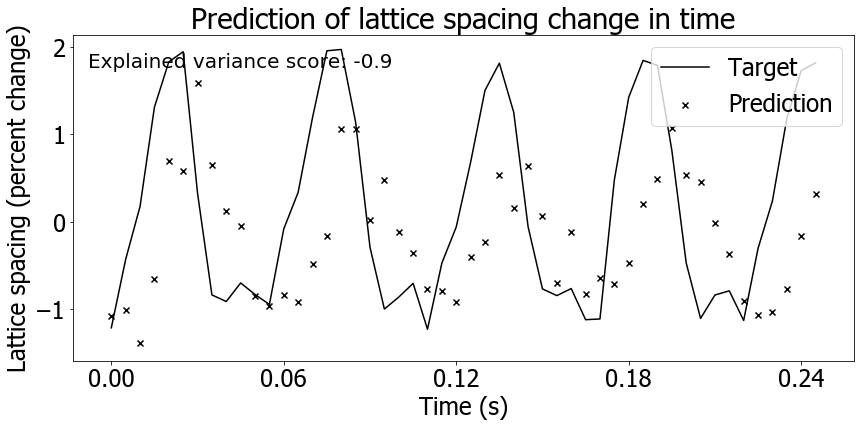

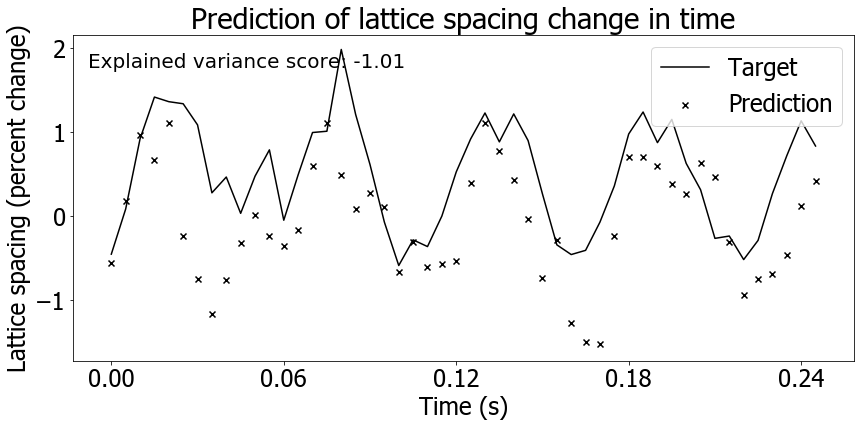

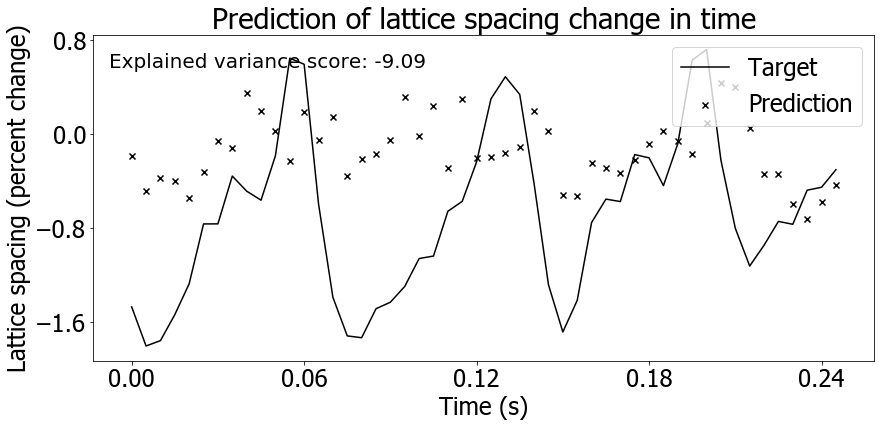

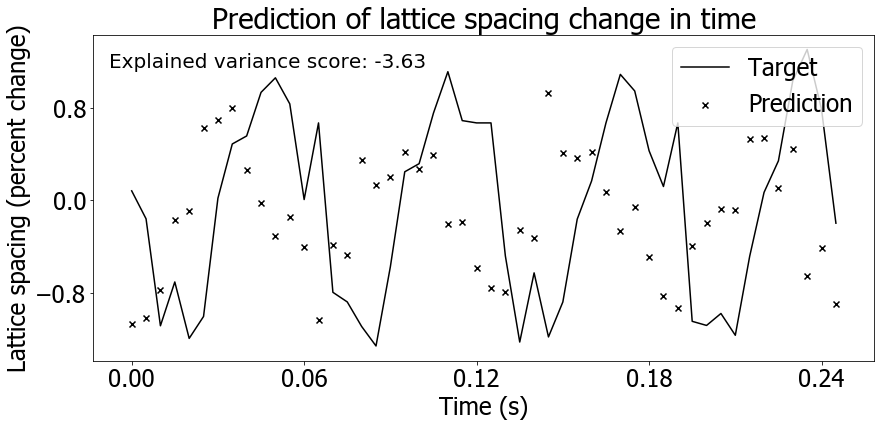

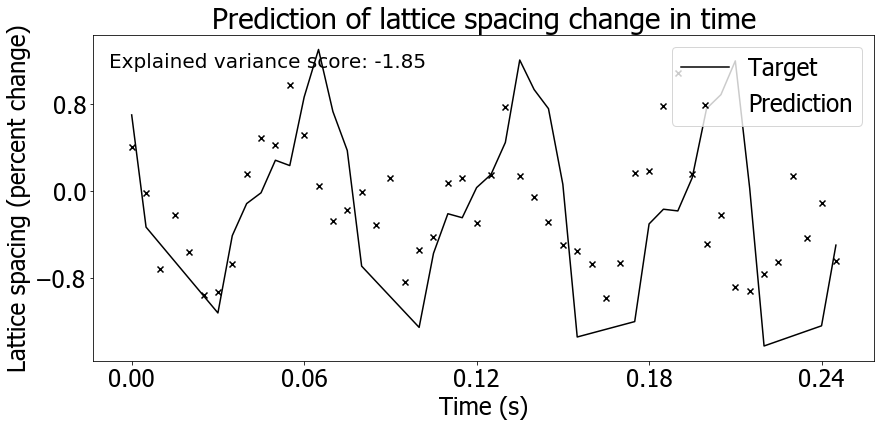

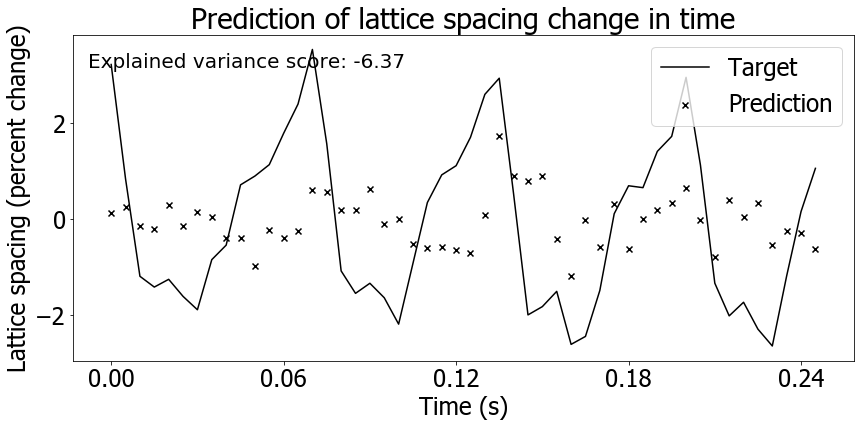

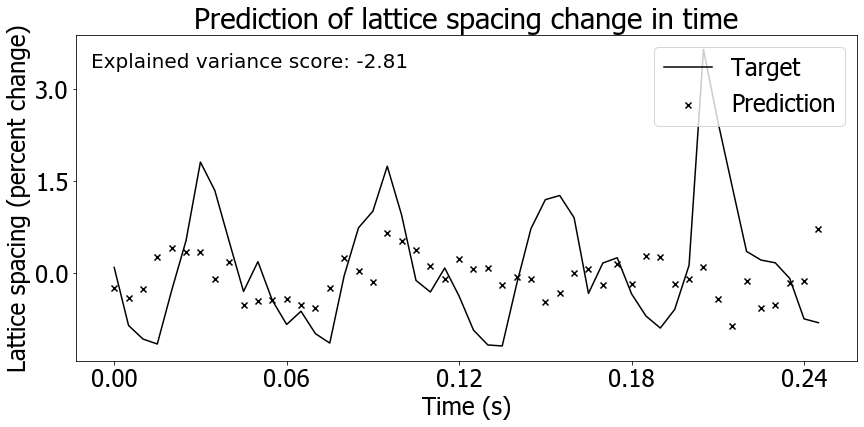

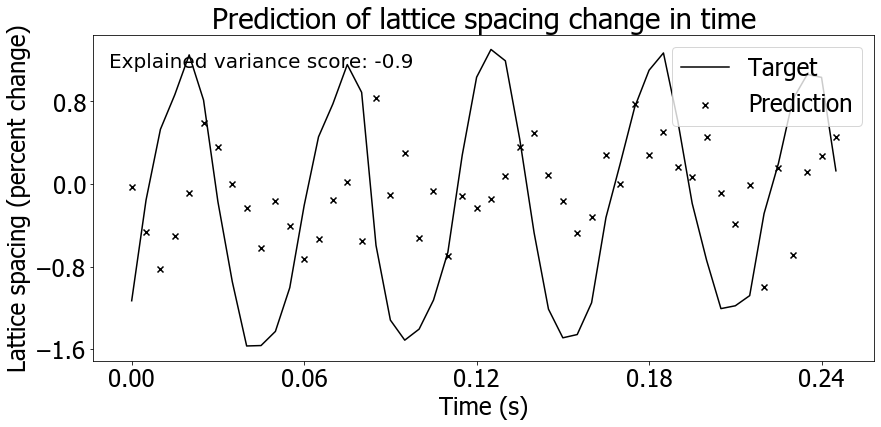

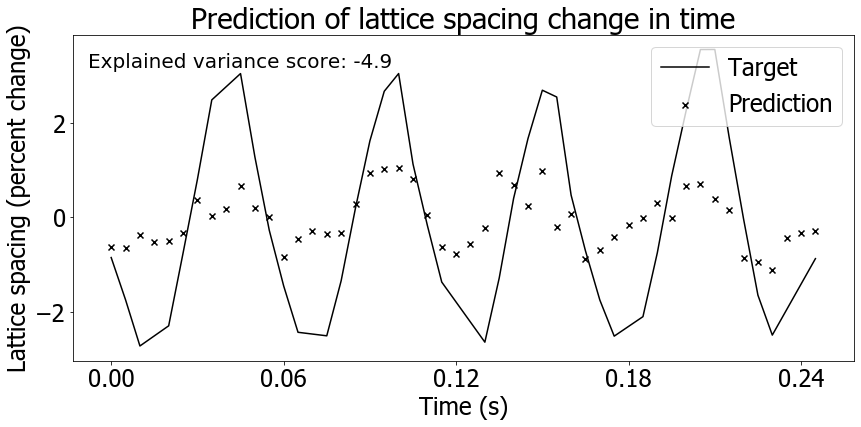

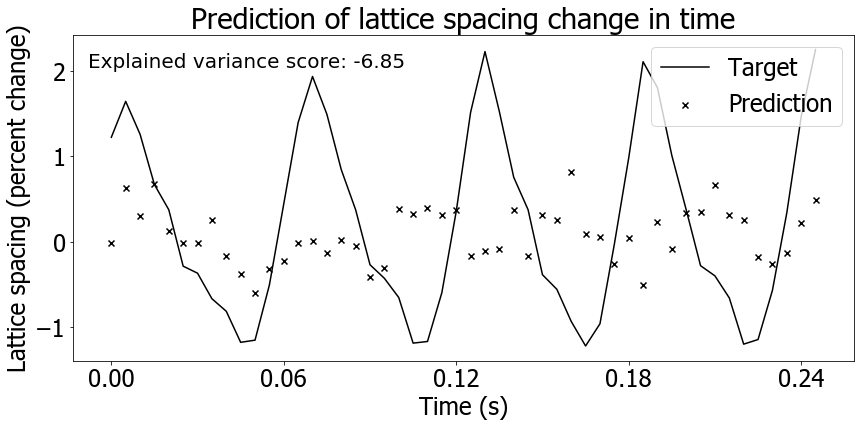

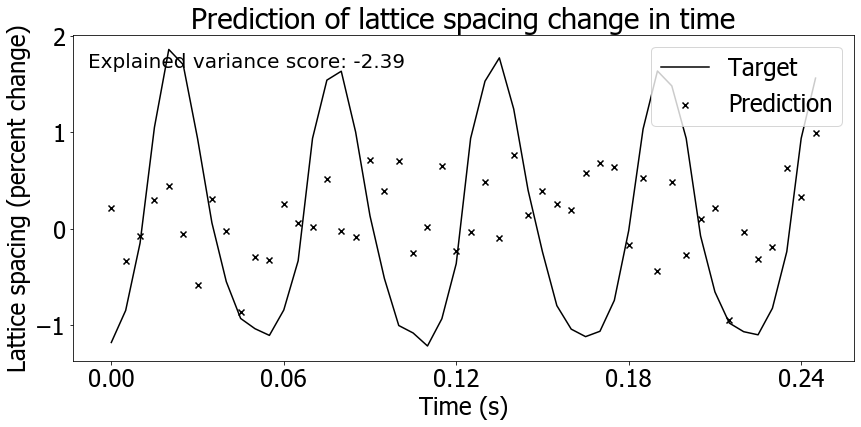

In [14]:
# train on N-1 of N trials and test on the removed trial

test_column = 'D10'
predictor_columns = ['Wingbeat_freq', 'M6_c', 'I20_I10', 'M3_i', 'A59_c']
#exp_var = pandas.DataFrame(np.zeros(len(acceptable_trials))*np.nan, index = [np.arange(0,len(acceptable_trials))], columns = ['Explained_variance'])
exp_var_all_trials = pandas.DataFrame((np.zeros((len(acceptable_trials),2)))*np.nan, index = [np.arange(0,len(acceptable_trials))], columns = ['Explained_variance', 'rms'])

for i in np.arange(0,len(train_trials)): 
    xg_reg = xgb.XGBRegressor(objective =obj, colsample_bytree = csbt, learning_rate = lr,
                max_depth = md, n_estimators = n_est, subsample = ss, alpha = alp)
    
    
    
    # Prep the data
    
    # Base case
    trial = train_trials[i][0]
    d = pandas.read_csv('../DataProcessing/ProcessedData/' + trial + '_det.csv')
    d = d[['D10', 'D11', 'D20', 'I20I11_I10', 'I20_I10',
           'fitting_error', 'seconds', 'tif_num', 'M3_c', 'M6_c', 'A51_c', 'A59_c',
           'M3_i', 'M6_i', 'A59_i', 'A51_i', 'Sum', 'peaks', 'ISI']]
    
    d['M3_c'] = 100*(d.M3_c/d.M3_c.mean() - 1)
    d['M6_c'] = 100*(d.M6_c/d.M6_c.mean() - 1)
    d['A59_c'] = 100*(d.A59_c/d.A59_c.mean() - 1)
    d['D10'] = 100*(d.D10/d.D10.mean() - 1)
    
    d = d.interpolate()
    d['Wingbeat_freq'] = d.ISI.max()
    d = d[['D10', 'I20_I10', 'M3_i', 'A59_c', 'M6_c', 'Wingbeat_freq', 'peaks']]
    d = d.dropna(how = 'any').reset_index(drop = 'True')
    
    
    columns = ['M3_i', 'M6_c', 'I20_I10', 'A59_c']
    shift_column_names = []
    for col in columns:
        d[col + '_' + str(0)] = d[col].shift(-1)
        shift_column_names.append(col + '_' + str(0))

    for j in np.arange(1,11):
        for col in columns:
            d[col + '_' + str(j)] = d[col + '_' + str(j - 1)].shift(-1)
            shift_column_names.append(col + '_' + str(j))

    d = d.dropna()
    
    # Subset the data into predictors (X) and predicted (y)
    X = (d[columns + shift_column_names])
    y = (d[['D10']])
    
    
    
    # Subsequent cases
    
    # Create training set
    for trial in train_trials[i][1:]: 
        d = pandas.read_csv('../DataProcessing/ProcessedData/' + trial + '_det.csv')
        d = d[['D10', 'D11', 'D20', 'I20I11_I10', 'I20_I10',
               'fitting_error', 'seconds', 'tif_num', 'M3_c', 'M6_c', 'A51_c', 'A59_c',
               'M3_i', 'M6_i', 'A59_i', 'A51_i', 'Sum', 'peaks', 'ISI']]
        
        d['M3_c'] = 100*(d.M3_c/d.M3_c.mean() - 1)
        d['M6_c'] = 100*(d.M6_c/d.M6_c.mean() - 1)
        d['A59_c'] = 100*(d.A59_c/d.A59_c.mean() - 1)
        d['D10'] = 100*(d.D10/d.D10.mean() - 1)
        
        d = d.interpolate()
        d['Wingbeat_freq'] = d.ISI.max()
        d = d[['D10', 'I20_I10', 'M3_i', 'A59_c', 'M6_c', 'Wingbeat_freq', 'peaks']]
        d = d.dropna(how = 'any').reset_index(drop = 'True')
        
        
   
        for col in columns:
            d[col + '_' + str(0)] = d[col].shift(-1)
            #shift_column_names.append(col + '_' + str(0))

        for j in np.arange(1,11):
            for col in columns:
                d[col + '_' + str(j)] = d[col + '_' + str(j - 1)].shift(-1)
                #shift_column_names.append(col + '_' + str(i))


        d = d.dropna()
        
        # Subset the data into predictors (X) and predicted (y)
        X = X.append(d[columns + shift_column_names])
        y = y.append(d[['D10']])
           
    X = X.reset_index(drop = 'True')
    y = y.reset_index(drop = 'True')
    
    xg_reg.fit(X, y)
    y_pred = xg_reg.predict(X)
    
    # Use the last df as a test set
    trial = test_trials[i]
    d = pandas.read_csv('../DataProcessing/ProcessedData/' + trial + '_det.csv')
    d = d[['D10', 'D11', 'D20', 'I20I11_I10', 'I20_I10',
           'fitting_error', 'seconds', 'tif_num', 'M3_c', 'M6_c', 'A51_c', 'A59_c',
           'M3_i', 'M6_i', 'A59_i', 'A51_i', 'Sum', 'peaks', 'ISI']]
    
    d['M3_c'] = 100*(d.M3_c/d.M3_c.mean() - 1)
    d['M6_c'] = 100*(d.M6_c/d.M6_c.mean() - 1)
    d['A59_c'] = 100*(d.A59_c/d.A59_c.mean() - 1)
    d['D10'] = 100*(d.D10/d.D10.mean() - 1)
    
    d = d.interpolate()
    d['Wingbeat_freq'] = d.ISI.max()
    d = d[['D10', 'I20_I10', 'M3_i', 'A59_c', 'M6_c', 'Wingbeat_freq', 'peaks']]
    d = d.dropna(how = 'any').reset_index(drop = 'True')

    for col in columns:
        d[col + '_' + str(0)] = d[col].shift(-1)

    for j in np.arange(1,11):
        for col in columns:
            d[col + '_' + str(j)] = d[col + '_' + str(j - 1)].shift(-1)

    d = d.dropna()

    X = (d[columns + shift_column_names])
    y = (d[['D10']])
    
    
    # Use the trained regressor to predict y from the test set X
    y_pred = xg_reg.predict(X)
    
    exp_var_all_trials.iloc[i] = explained_variance_score(y_pred,y)
    exp_var_all_trials.rms.iloc[i] = round(((sum((np.concatenate(np.array(y)) - y_pred)**(2)))/len(y_pred))**(1/2), 3)
    
    
    plt.rcParams['figure.figsize'] = [14, 6]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot((np.arange(0,len(y))*(1/200))[0:50], y[0:50], c = 'black', label = 'Target')
    ax.scatter((np.arange(0,len(y))*(1/200))[0:50], y_pred[0:50], c = 'black', marker = 'x', label = 'Prediction')
    ax.legend(loc = 'upper right')
    ax.set_title('Prediction of lattice spacing change in time')
    ax.set_ylabel('Lattice spacing (percent change)')
    ax.set_xlabel('Time (s)')
    ax.text(0.02,.9, 'Explained variance score: ' + str(round(explained_variance_score(y_pred,y), 2)), family="sans-serif", fontsize = 20, transform=ax.transAxes) # 0.03, 2.,
    ax.yaxis.set_major_locator(plt.MaxNLocator(4)) 
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    #plt.savefig('/Users/sagemalingen/Desktop/RandomForest_Figs/Predicted_AllTrialTrain_' + test_trials[i] + '.png', dpi = 400)
    plt.show()
    #plt.cla()



In [15]:
print('rms all trials: ', exp_var_all_trials.rms.mean(), ' SD: ', exp_var_all_trials.rms.std(), ' individual trials: ', exp_var.rms.mean(),' SD: ', exp_var.rms.std())

rms all trials:  1.0311818181818182  SD:  0.2978290846045154  individual trials:  0.6666363636363635  SD:  0.2452049235750672


In [16]:
print('exp var all trials: ', exp_var_all_trials.Explained_variance.mean(), ' SD: ',  exp_var_all_trials.Explained_variance.std(), ' individual trials: ', exp_var.Explained_variance.mean(), ' SD: ', exp_var.Explained_variance.std())

exp var all trials:  -3.7003806444713265  SD:  2.762720801772743  individual trials:  0.25181818181818183  SD:  0.7204001413356078
